In [1]:
import numpy as np
import torch

from transformers import SpeechT5Processor, SpeechT5ForSpeechToText, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed

from datasets import load_dataset
import torch

from IPython.display import Audio

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Data

In [3]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

Found cached dataset librispeech_asr_demo (/export/home/lium/bdos/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


#### Audio

In [4]:
example_speech = dataset[40]["audio"]['array']

Audio(example_speech, rate=sampling_rate)

In [5]:
audios = [sample["audio"]["array"] for sample in dataset]
audios = audios[:4]
len(audios)

4

#### Text

In [6]:
example_text = dataset[40]["text"]
example_text

'A MAN SAID TO THE UNIVERSE SIR I EXIST'

In [7]:
texts = [sample["text"] for sample in dataset]
texts = texts[:4]
len(texts)

4

In [8]:
texts

['MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
 "NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER",
 'HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND',
 "HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIGHTON'S WORK IS REALLY GREEK AFTER ALL AND CAN DISCOVER IN IT BUT LITTLE OF ROCKY ITHACA"]

#### Process input

In [9]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")

In [10]:
speech_inputs = processor(audio=audios, sampling_rate=sampling_rate, return_tensors="pt", padding="longest").to(device)

In [11]:
text_inputs = processor(text=texts, return_tensors='pt', padding="longest").to(device)

In [12]:
text_inputs

{'input_ids': tensor([[ 4, 43, 30, 34, 32, 47, 54,  4, 65, 61, 30, 52, 32, 47, 54,  4, 30, 34,
          4, 32, 35, 47,  4, 33, 49, 50, 34, 32, 52, 47,  4, 50, 55,  4, 32, 35,
         47,  4, 43, 30, 51, 51, 52, 47,  4, 42, 52, 33, 34, 34, 47, 34,  4, 33,
         48, 51,  4, 38, 47,  4, 33, 54, 47,  4, 53, 52, 33, 51,  4, 32, 50,  4,
         38, 47, 52, 42, 50, 43, 47,  4, 35, 30, 34,  4, 53, 50, 34, 49, 47, 52,
          2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 4, 48, 50, 54,  4, 30, 34,  4, 43, 30, 34, 32, 47, 54,  4, 65, 61, 30,
         52, 32, 47, 54, 31, 34,  4, 43, 33, 48, 48, 47, 54,  4, 52, 47, 34, 34,
          4, 30, 48, 32, 47, 54, 47, 

## 2. Model

#### Speech

In [13]:
model_stt = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")
model_stt = model_stt.to(device)

In [14]:
predicted_ids_speech = model_stt.generate(**speech_inputs, max_length=100)

#### Text

In [15]:
model_tts = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
model_tts = model_tts.to(device)

In [16]:
n = len(texts)
speaker_embeddings = torch.zeros((n, 512)).to(device)
set_seed(555)

#Or optional, to make the generated text sound better
#embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
#speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0).to(device)

In [17]:
#spectrogram = model_tts.generate_speech(**text_inputs, speaker_embeddings)

## 3. Outputs

#### Automatic Speech Recognition

In [18]:
transcription = processor.batch_decode(predicted_ids_speech, skip_special_tokens=True)
print(transcription[0])

mister quilter is the apostle of the middle classes and we are glad to welcome his gospel


#### Tex-to-Speech

In [19]:
#vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
#vocoder = vocoder.to(device)

#with torch.no_grad():
#    generated_speech = vocoder(spectrogram)
    
#Audio(generated_speech.cpu(), rate=sampling_rate)

## 4. Embeddings (Speech separate from Text)

#### Speech

In [20]:
out_stt = model_stt(**speech_inputs, decoder_input_ids=predicted_ids_speech)

In [21]:
speech_embeddings = out_stt.encoder_last_hidden_state

In [22]:
speech_embeddings.shape

torch.Size([4, 624, 768])

#### Text

In [23]:
decoder_input_values = torch.zeros((n, 1024, 80)).to(device) #(batch_size, sequence_length, num_mel_bins)
out_tts = model_tts(**text_inputs, speaker_embeddings=speaker_embeddings, decoder_input_values=decoder_input_values)

In [24]:
text_embeddings = out_tts.encoder_last_hidden_state

In [25]:
text_embeddings.shape

torch.Size([4, 174, 768])

## Visualization (experiment)

In [26]:
flattened_speech_embeddings = speech_embeddings.reshape(-1, 768)
flattened_text_embeddings = text_embeddings.reshape(-1, 768)

In [27]:
pca = PCA(n_components=3)

In [28]:
pca_speech = pca.fit_transform(flattened_speech_embeddings.cpu().detach().numpy())
pca_text = pca.fit_transform(flattened_text_embeddings.cpu().detach().numpy())

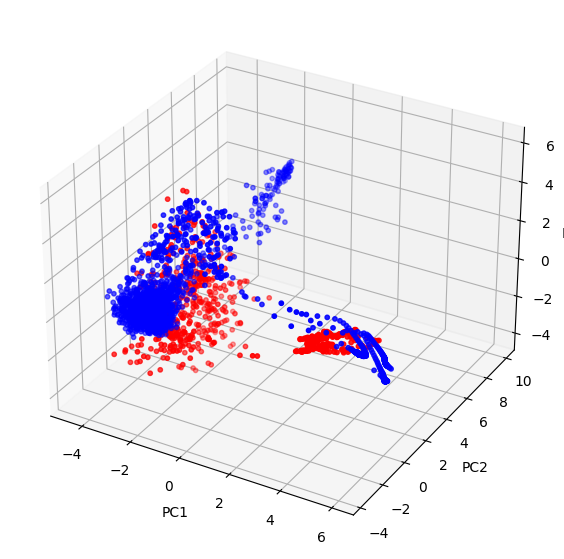

In [29]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Adding points on the 3D plot
ax.scatter3D(pca_speech[:,0], pca_speech[:,1], pca_speech[:,2], s=10, c='b')
ax.scatter3D(pca_text[:,0], pca_text[:,1], pca_text[:,2], s=10, c='r')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [25]:
#average...pooling...weighted average...self attention poooling....should be done to put them together...

## Averaging embeddings

Experiment 1

In [30]:
speech_embeddings_avg = torch.mean(speech_embeddings, dim=1, keepdim=True)
text_embeddings_avg = torch.mean(text_embeddings, dim=1, keepdim=True)

print(speech_embeddings_avg.shape, text_embeddings_avg.shape)

torch.Size([4, 1, 768]) torch.Size([4, 1, 768])


In [35]:
speech_embeddings_avg_vis = speech_embeddings_avg.squeeze(1)
text_embeddings_avg_vis = text_embeddings_avg.squeeze(1)

print(speech_embeddings_avg_vis.shape, text_embeddings_avg_vis.shape)

torch.Size([4, 768]) torch.Size([4, 768])


In [36]:
all_embeddings_avg = torch.cat((speech_embeddings_avg_vis, text_embeddings_avg_vis), dim=0)
all_embeddings_avg.shape

torch.Size([8, 768])

In [37]:
pca = PCA(n_components=3)
pca_avg = pca.fit_transform(all_embeddings_avg.cpu().detach().numpy())

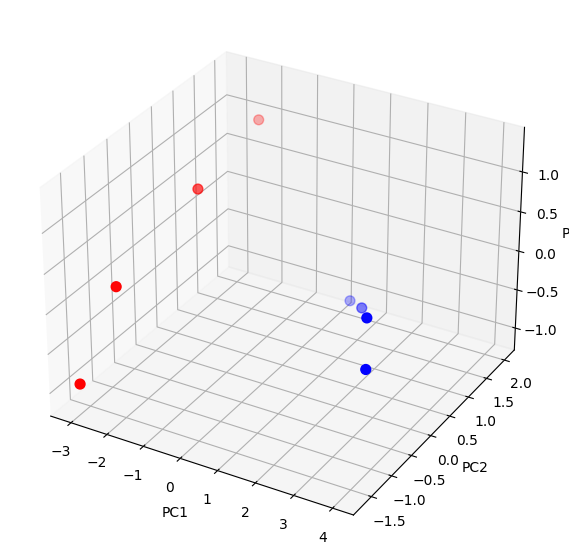

In [38]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Adding points on the 3D plot
ax.scatter3D(pca_avg[:4,0], pca_avg[:4,1], pca_avg[:4,2], s=50, c='b') # Speech points
ax.scatter3D(pca_avg[4:,0], pca_avg[4:,1], pca_avg[4:,2], s=50, c='r') # Text points

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [41]:
for i,text in enumerate(texts):
    print(i, ":", text)

0 : MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
1 : NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER
2 : HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND
3 : HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIGHTON'S WORK IS REALLY GREEK AFTER ALL AND CAN DISCOVER IN IT BUT LITTLE OF ROCKY ITHACA
